In [0]:
!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  7451k      0  0:00:01  0:00:01 --:--:-- 7446k


In [0]:
!mkdir mnist_dataset

In [2]:
import numpy
print(numpy.__version__)

1.14.6


In [3]:
import matplotlib
print(matplotlib.__version__)

3.0.2


In [4]:
import PIL
print(PIL.__version__)

4.0.0


In [5]:
import tensorflow
print(tensorflow.__version__)

1.12.0


In [6]:
import tqdm
print(tqdm.__version__)

4.28.1


In [0]:
import os
import gzip
import numpy as np
from tqdm import tqdm
from PIL import Image

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)[0]
  

def decompress_gzfile(extract_path, save_path):
    with open(extract_path, 'rb') as f:
        with gzip.GzipFile(fileobj=f) as bytestream:
            magic = _read32(bytestream)
            # https://stackoverflow.com/questions/54111609/why-does-the-python-mnist-parser-hardcode-the-value-2051
            if magic != 2051:
                raise ValueError('Invalid magic number {} in file: {}'.format(magic, f.name))
            num_images = _read32(bytestream) 
            rows = _read32(bytestream) 
            cols = _read32(bytestream) 
            buf = bytestream.read(rows * cols * num_images)
            data = np.frombuffer(buf, dtype=np.uint8)
            data = data.reshape(num_images, rows, cols)

    for image_i, image in enumerate(tqdm(data, 
                                         unit='File', 
                                         unit_scale=True, 
                                         miniters=1, 
                                         desc='提取MNIST数据集图像')):
        save_img_path = os.path.join(save_path, 'image_{}.jpg'.format(image_i))
        Image.fromarray(image, 'L').save(save_img_path)
        
extract_path = "train-images-idx3-ubyte.gz"
save_path = "mnist_dataset"
decompress_gzfile(extract_path, save_path)

In [14]:
from glob import glob
mnist_all_paths = glob(save_path + '/*.jpg')
mnist_all_paths[:10]

['mnist_dataset/image_26205.jpg',
 'mnist_dataset/image_53592.jpg',
 'mnist_dataset/image_6381.jpg',
 'mnist_dataset/image_7547.jpg',
 'mnist_dataset/image_22247.jpg',
 'mnist_dataset/image_2355.jpg',
 'mnist_dataset/image_40473.jpg',
 'mnist_dataset/image_32139.jpg',
 'mnist_dataset/image_29817.jpg',
 'mnist_dataset/image_41088.jpg']

In [9]:
len(mnist_all_paths)

60000

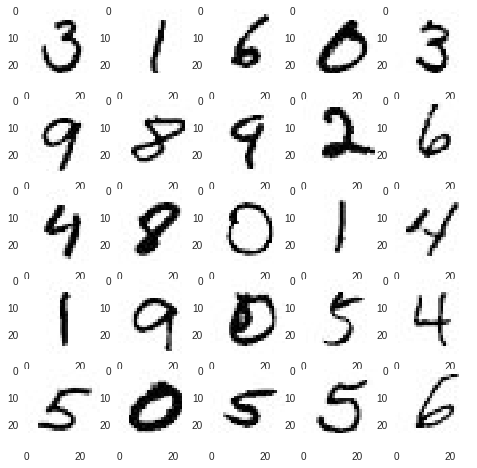

In [10]:
import matplotlib.pyplot as plt
from matplotlib import image 
import random

def plot_random_25_img(filepaths):
    random_25_imgs = random.sample(filepaths, 25)
    fig, axes = plt.subplots(nrows=5, ncols=5)
    fig.set_size_inches(8, 8)
    index = 0
    for row_index in range(5): 
        for col_index in range(5): 
            img = image.imread(random_25_imgs[index])
            ax = axes[row_index, col_index]
            ax.imshow(img)
            ax.grid(False)
            index += 1
            
plot_random_25_img(mnist_all_paths)

In [0]:
import tensorflow as tf

def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real =  tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, learning_rate

In [0]:
def leaky_relu(x, alpha):
    return tf.maximum(x * alpha, x)

In [0]:
def discriminator(images, reuse=False):
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.9)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.9)

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

In [0]:
def generator(z, out_channel_dim, is_train=True, reuse=True):
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
       
        out = tf.tanh(logits) 
    
    return out

In [0]:
def model_loss(input_real, input_z, out_channel_dim):
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = \
    tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = \
    tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss
  

In [0]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


In [0]:
from PIL import Image
from PIL import ImageOps

def images_square_grid(images, mode):
    save_size = int(math.floor(np.sqrt(images.shape[0]))) 
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8) 
    images_in_square = np.reshape(images[:save_size*save_size], (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            if mode == "L":
                im = ImageOps.invert(im)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))
    return new_im

In [0]:
import matplotlib.pyplot as plt

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = images_square_grid(samples, image_mode)
    plt.imshow(images_grid, cmap=cmap)
    plt.grid(False)
    plt.show()

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        iteration = 0
        for epoch_i in range(epoch_count):
            batches_generator = get_batches(batch_size)
            for batch_images in batches_generator:
                z_ = np.random.uniform(-1, 1, (batch_size, z_dim)) 
                _ = sess.run(d_optimizer, feed_dict={inputs_real:batch_images*2, inputs_z:z_}) 
                _ = sess.run(g_optimizer, feed_dict={inputs_z:z_, inputs_real:batch_images,})
                iteration += 1 
                if iteration % 10 == 0:
                    d_loss_ = d_loss.eval({inputs_z:z_, inputs_real:batch_images})
                    g_loss_ = g_loss.eval({inputs_z:z_})
                    print("Iteration: {}, d_loss_={:.5f}, g_loss_={:.5f}".format(iteration, d_loss_, g_loss_))
                if iteration % 50 == 0: 
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
    

In [0]:
import math
class Dataset(object):

    def __init__(self, dataset_name, data_files):
        DATASET_LFW_NAME = 'lfw'
        DATASET_MNIST_NAME = 'mnist'
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28 
        
        if dataset_name == DATASET_LFW_NAME:
            self.image_mode = 'RGB'
            image_channels = 3 
        elif dataset_name == DATASET_MNIST_NAME:
            self.image_mode = 'L'
            image_channels = 1 
            
        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels
        
        
    def get_batches(self, batch_size):
        IMAGE_MAX_VALUE = 255
        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = self.get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                mode=self.image_mode)
            current_index += batch_size
            yield data_batch / IMAGE_MAX_VALUE - 0.5
            
    def get_batch(self, image_files, width, height, mode):
        data_batch = np.array(
            [self.get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)
        if len(data_batch.shape) < 4:
            data_batch = data_batch.reshape(data_batch.shape + (1,))
        return data_batch
      
    def get_image(self, image_path, width, height, mode):
        image = Image.open(image_path)
        if image.size != (width, height): 
            face_width = face_height = 108
            j = (image.size[0] - face_width) // 2
            i = (image.size[1] - face_height) // 2
            image = image.crop([j, i, j + face_width, i + face_height])
            image = image.resize([width, height], Image.BILINEAR)
        return np.array(image.convert(mode))

In [15]:
batch_size = 64 
z_dim = 100
learning_rate = 0.001
beta1 = 0.5
epochs = 20

mnist_dataset = Dataset('mnist', mnist_all_paths)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, 
          beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Output hidden; open in https://colab.research.google.com to view.